# Liquid freshwater content (LFWC) in the Subpolar North Atlantic (SPNA)

In [1]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
salem.__version__

'0.2.2'

In [3]:
xr.__version__

u'0.10.8'

### Load datasets

#### HadOBS EN4

In [4]:
ds = xr.open_dataset('/home/jet/data/hadobs/converted/en4/salinity.nc')

#### Area

In [5]:
nc = xr.open_dataset('/home/jet/data/hadobs/hadobs_en4_area.nc')
ds['area'] = nc.area
ds.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [6]:
south = 45
north = 90
west = -110
east = 45

tstart = '1900-01-15'
tend = '2017-12-15'

In [7]:
psal = ds.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

## Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [8]:
psal_ref = 34.80

In [9]:
f = (psal_ref - psal)/psal_ref

### Array of grid height (`dz`)

In [10]:
#depth_bnds = ds.depth_bnds.sel(time=slice(tstart,tend),lon=slice(west,east))
depth_bnds = ds.depth_bnds

In [11]:
dz = (depth_bnds[:,1]-depth_bnds[:,0])

### Sum over depth levels

In [12]:
print depth_bnds.max().values

5500.0


In [13]:
#D = 2012.5
D = 5500.0
print np.shape(f)
print np.shape((f * dz).sel(depth=slice(0,D)))

(1416, 42, 45, 156)
(1416, 42, 45, 156)


In [14]:
h_fw = (f * dz).sel(depth=slice(0,D)).sum('depth')

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

For the subpolar gyre (SPG) we take the common spatial range of 50-62N and 10-60W

#### Define regions: Subpolar North Atlantic (`spna`)

In [15]:
coords_spna = [-9.4, 50,
               -56.8, 50,
               -67.5, 62.3,
               -61.6, 66.7,
               -35, 66.7,
               -22.1, 66.1,
               -3.8, 59,
               -9.4, 50]

In [16]:
# Replace each pair of points by 10 points for projected map
geometry = []
segments = zip(coords_spna[:-2:2], coords_spna[1:-1:2], coords_spna[2::2], coords_spna[3::2])
for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
    for length in np.linspace(0,1,11):
        geometry.append( line.interpolate(length, normalized=True) )
        
gdf_spna = gpd.GeoDataFrame([], geometry=geometry)

# Convert Points to Polygon
gdf_spna['geometry'] = gdf_spna['geometry'].apply(lambda x: x.coords[0])

gdf_spna['shape_id'] = 0
gdf_spna = gdf_spna.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()

gdf_spna = gpd.GeoDataFrame(gdf_spna, geometry = 'geometry')

# Salem uses this attribute:
gdf_spna.crs = {'init': 'epsg:4326'}

In [17]:
h_fw_spna = h_fw.salem.roi(shape=gdf_spna.loc[[0]])

In [18]:
h_fw_spna = h_fw.salem.roi(shape=gdf_spna.loc[[0]])

/opt/rh/python27/root/usr/lib/python2.7/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


/opt/rh/python27/root/usr/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


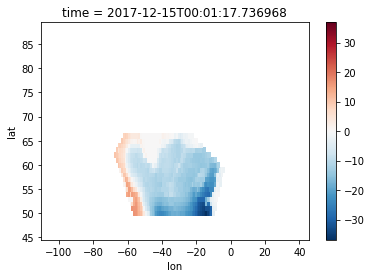

In [19]:
h_fw_spna[-1].plot()

In [20]:
lfwc_spna = (h_fw_spna * ds.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
lfwc_spna = lfwc_spna*1e-9

In [21]:
ds = lfwc_spna.to_dataset(name='lfwc')

In [22]:
ds.time.attrs = []

In [23]:
ds.to_netcdf('/home/jet/data/hadobs/hadobs_en4_lfwc_spna_monthly.nc', format='NETCDF4',
               encoding={'lfwc':   {'zlib': True}})